In [6]:
import numpy as np
import re
import nltk
from datasets import load_dataset
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize

import torch
import torch.nn as nn
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import TensorDataset, DataLoader
import torch.optim as optim
import torch.nn.functional as F

from sklearn.metrics import accuracy_score
from sklearn.model_selection import ParameterGrid

import matplotlib.pyplot as plt

In [7]:
nltk.download('all')

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /Users/Lancer/nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to
[nltk_data]    |     /Users/Lancer/nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /Users/Lancer/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger is already up-
[nltk_data]    |       to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_eng to
[nltk_data]    |     /Users/Lancer/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger_eng is already
[nltk_data]    |       up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /Users/Lancer/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger_ru is already
[nltk_data]    |       up-to-date!
[nlt

True

# Part 0. Dataset Preparation

In [8]:
# loading the dataset from the library
dataset = load_dataset("rotten_tomatoes")
train_dataset = dataset ['train']
validation_dataset = dataset ['validation']
test_dataset = dataset ['test']

In [9]:
# check the sizes of each dataset
train_size = len(train_dataset)
validation_size = len(validation_dataset)
test_size = len(test_dataset)

print(f"Training dataset size: {train_size}")
print(f"Validation dataset size: {validation_size}")
print(f"Test dataset size: {test_size}")

Training dataset size: 8530
Validation dataset size: 1066
Test dataset size: 1066


In [10]:
# view an example from each dataset
print("Train Dataset")
print(train_dataset.features)
print(train_dataset[0]) 

print("Test Dataset")
print(test_dataset.features)
print(test_dataset[0]) 

print("Validation Dataset")
print(validation_dataset.features)
print(validation_dataset[0])

Train Dataset
{'text': Value(dtype='string', id=None), 'label': ClassLabel(names=['neg', 'pos'], id=None)}
{'text': 'the rock is destined to be the 21st century\'s new " conan " and that he\'s going to make a splash even greater than arnold schwarzenegger , jean-claud van damme or steven segal .', 'label': 1}
Test Dataset
{'text': Value(dtype='string', id=None), 'label': ClassLabel(names=['neg', 'pos'], id=None)}
{'text': 'lovingly photographed in the manner of a golden book sprung to life , stuart little 2 manages sweetness largely without stickiness .', 'label': 1}
Validation Dataset
{'text': Value(dtype='string', id=None), 'label': ClassLabel(names=['neg', 'pos'], id=None)}
{'text': 'compassionately explores the seemingly irreconcilable situation between conservative christian parents and their estranged gay and lesbian children .', 'label': 1}


# Part 1. Preparing Word Embeddings

### Preprocessing

In [11]:
def preprocessing(text):

    # remove any other special characters but keep the general ones for potential sentiment usage
    text = re.sub(r'[^a-zA-Z0-9\'\!\?\.]', ' ', text)

    # replace multiple spaces with one space only
    text = re.sub(r'\s+', ' ', text)

    # remove leading and trailing whitespace to avoid unnecessary inconsistency
    text = text.strip()

    # convert the text to lowercase
    text = text.lower()


    return text

# apply the preprocessing function to the 'text' column of each dataset
train_dataset = train_dataset.map(lambda x: {'text': preprocessing(x['text'])})
validation_dataset = validation_dataset.map(lambda x: {'text': preprocessing(x['text'])})
test_dataset = test_dataset.map(lambda x: {'text': preprocessing(x['text'])})

# an example of the processed text
print("Train Dataset Example:")
print(train_dataset[0])

Map: 100%|██████████| 1066/1066 [00:00<00:00, 35887.60 examples/s]

Train Dataset Example:
{'text': "the rock is destined to be the 21st century's new conan and that he's going to make a splash even greater than arnold schwarzenegger jean claud van damme or steven segal .", 'label': 1}


In [12]:
# tokenization
# empty list to store the resulting sentences
tokenized_sentences = []

for text in train_dataset['text']:
    # Tokenize the text and append the tokenized sentence to the list
    tokenized_sentences.append(word_tokenize(text))

### (a) Size of vocabulary in training data

In [13]:
# empty set for storing unique words
original_vocab = set()

for sentence in tokenized_sentences:
    for word in sentence:
        # add each word in the sentence to the words set
        original_vocab.add(word)

print(f"(a) The size of vocabulary formed in the training data is {len(original_vocab)}")

(a) The size of vocabulary formed in the training data is 16683


### (b) Number of OOV in the training data

In [14]:
# adjust the parameters for word2vec
vector_size = 100 # Dimensionality of the word vectors
window = 3 # Maximum distance between the current and predicted word within a sentence
min_count = 2 # Ignores all words with total frequency lower than this
workers = 4 # CPU cores
sg = 1 # 1 for skip-gram, 0 for CBOW
epochs = 5 

# train the word2vec model
word2vec_model = Word2Vec(
    sentences = tokenized_sentences, 
    vector_size = vector_size, 
    window = window, 
    min_count = min_count, 
    workers = workers,
    epochs = epochs)

# variable to store model's vocab list 
word2vec_vocab = set(word2vec_model.wv.key_to_index)

# Calculate OOV words by comparing the original vocab and Word2Vec vocab
oov_words = original_vocab - word2vec_vocab

print(f"(b) Number of OOV words in the training data is {len(oov_words)} when the minimum threshold for each word is {min_count}")

(b) Number of OOV words in the training data is 7866 when the minimum threshold for each word is 2


### (c) Mitigating OOV

In [15]:
# Replace all OOV words with <UNK>

# define the UNK and PAD token
UNK_TOKEN = '<UNK>'
PAD_TOKEN = '<PAD>'

# process each sentence in the tokenized_sentences list
for i, sentence in enumerate(tokenized_sentences):
    # empty list to store the current processed sentence
    processed_sentence = []
    for word in sentence:
        if word in word2vec_vocab:
            # if the current word is in the model's vocab, keep it as it is
            processed_sentence.append(word)  
        else:
            # otherwise, replace the word with UNK
            processed_sentence.append(UNK_TOKEN) 

    # update the sentence in the original tokenized_sentences list
    tokenized_sentences[i] = processed_sentence

### Embedding matrix

In [16]:
# empty set for storing unique words
final_vocab = set()

for sentence in tokenized_sentences:
    for word in sentence:
        # add each word in the sentence to the final_vocab set
        final_vocab.add(word)

# add 'UNK' and '<PAD>' to the vocabulary
final_vocab.add(UNK_TOKEN)
final_vocab.add(PAD_TOKEN)

# create the dictionary that maps each word in final_vocab to a unique index
word_to_index = {word: i for i, word in enumerate(final_vocab)}

embedding_dim = word2vec_model.vector_size 

# initialize embedding matrix with number of vocab and embedding dimension
embedding_matrix = np.zeros((len(word_to_index), embedding_dim))

# fill the embedding matrix with the corresponding word vectors
for word, i in word_to_index.items():
    if word in word2vec_model.wv:
        embedding_matrix[i] = word2vec_model.wv[word]
    else:
        # (option 1) random initialization for unknown words 
        embedding_matrix[i] = np.random.normal(scale=0.6, size=(embedding_dim,))
        # (option 2) use average vector for unknown words 
        # embedding_matrix[i] = np.mean(word2vec_model.wv.vectors, axis=0)

print(f"Shape of embedding matrix: {embedding_matrix.shape}")

Shape of embedding matrix: (8819, 100)


In [17]:
# convert word to indices 
def words_to_indices(sentence, word_to_index):
    return [word_to_index.get(word, word_to_index[UNK_TOKEN]) for word in sentence.split()]

train_X = [words_to_indices(sentence, word_to_index) for sentence in train_dataset['text']]
train_y = train_dataset['label']
val_X = [words_to_indices(sentence, word_to_index) for sentence in validation_dataset['text']]
val_y = validation_dataset['label']
test_X = [words_to_indices(sentence, word_to_index) for sentence in test_dataset['text']]
test_y = test_dataset['label']

def create_dataloader(X, y, batch_size=16, shuffle=True):
    X_tensor = [torch.tensor(seq, dtype=torch.long) for seq in X]
    X_padded = pad_sequence(X_tensor, batch_first=True, padding_value=word_to_index[PAD_TOKEN])
    y_tensor = torch.tensor(y, dtype=torch.long)
    dataset = TensorDataset(X_padded, y_tensor)
    return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)

train_dataloader = create_dataloader(train_X, train_y, shuffle=True)
val_dataloader = create_dataloader(val_X, val_y, shuffle=False)
test_dataloader = create_dataloader(test_X, test_y, shuffle=False)

# convert embedding_matrix to tensor
embedding_matrix = torch.FloatTensor(embedding_matrix)

In [18]:
# empty set for storing unique words
final_vocab = set()

for sentence in tokenized_sentences:
    for word in sentence:
        # add each word in the sentence to the final_vocab set
        final_vocab.add(word)

# add 'UNK' and '<PAD>' to the vocabulary
final_vocab.add(UNK_TOKEN)
final_vocab.add(PAD_TOKEN)

# create the dictionary that maps each word in final_vocab to a unique index
word_to_index = {word: i for i, word in enumerate(final_vocab)}

embedding_dim = word2vec_model.vector_size 

# initialize embedding matrix with number of vocab and embedding dimension
embedding_matrix = np.zeros((len(word_to_index), embedding_dim))

# fill the embedding matrix with the corresponding word vectors
for word, i in word_to_index.items():
    if word in word2vec_model.wv:
        embedding_matrix[i] = word2vec_model.wv[word]
    else:
        # (option 1) random initialization for unknown words 
        embedding_matrix[i] = np.random.normal(scale=0.6, size=(embedding_dim,))
        # (option 2) use average vector for unknown words 
        # embedding_matrix[i] = np.mean(word2vec_model.wv.vectors, axis=0)

print(f"Shape of embedding matrix: {embedding_matrix.shape}")

Shape of embedding matrix: (8819, 100)


In [19]:
# convert word to indices 
def words_to_indices(sentence, word_to_index):
    return [word_to_index.get(word, word_to_index[UNK_TOKEN]) for word in sentence.split()]

train_X = [words_to_indices(sentence, word_to_index) for sentence in train_dataset['text']]
train_y = train_dataset['label']
val_X = [words_to_indices(sentence, word_to_index) for sentence in validation_dataset['text']]
val_y = validation_dataset['label']
test_X = [words_to_indices(sentence, word_to_index) for sentence in test_dataset['text']]
test_y = test_dataset['label']

def create_dataloader(X, y, batch_size=16, shuffle=True):
    X_tensor = [torch.tensor(seq, dtype=torch.long) for seq in X]
    X_padded = pad_sequence(X_tensor, batch_first=True, padding_value=word_to_index[PAD_TOKEN])
    y_tensor = torch.tensor(y, dtype=torch.long)
    dataset = TensorDataset(X_padded, y_tensor)
    return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)

train_dataloader = create_dataloader(train_X, train_y, shuffle=True)
val_dataloader = create_dataloader(val_X, val_y, shuffle=False)
test_dataloader = create_dataloader(test_X, test_y, shuffle=False)

# convert embedding_matrix to tensor
embedding_matrix = torch.FloatTensor(embedding_matrix)

### (c) Mitigating OOV

In [20]:
# Replace all OOV words with <UNK>

# define the UNK and PAD token
UNK_TOKEN = '<UNK>'
PAD_TOKEN = '<PAD>'

# process each sentence in the tokenized_sentences list
for i, sentence in enumerate(tokenized_sentences):
    # empty list to store the current processed sentence
    processed_sentence = []
    for word in sentence:
        if word in word2vec_vocab:
            # if the current word is in the model's vocab, keep it as it is
            processed_sentence.append(word)  
        else:
            # otherwise, replace the word with UNK
            processed_sentence.append(UNK_TOKEN) 

    # update the sentence in the original tokenized_sentences list
    tokenized_sentences[i] = processed_sentence

### Embedding matrix

In [21]:
# empty set for storing unique words
final_vocab = set()

for sentence in tokenized_sentences:
    for word in sentence:
        # add each word in the sentence to the final_vocab set
        final_vocab.add(word)

# add 'UNK' and '<PAD>' to the vocabulary
final_vocab.add(UNK_TOKEN)
final_vocab.add(PAD_TOKEN)

# create the dictionary that maps each word in final_vocab to a unique index
word_to_index = {word: i for i, word in enumerate(final_vocab)}

embedding_dim = word2vec_model.vector_size 

# initialize embedding matrix with number of vocab and embedding dimension
embedding_matrix = np.zeros((len(word_to_index), embedding_dim))

# fill the embedding matrix with the corresponding word vectors
for word, i in word_to_index.items():
    if word in word2vec_model.wv:
        embedding_matrix[i] = word2vec_model.wv[word]
    else:
        # (option 1) random initialization for unknown words 
        embedding_matrix[i] = np.random.normal(scale=0.6, size=(embedding_dim,))
        # (option 2) use average vector for unknown words 
        # embedding_matrix[i] = np.mean(word2vec_model.wv.vectors, axis=0)

print(f"Shape of embedding matrix: {embedding_matrix.shape}")

Shape of embedding matrix: (8819, 100)


In [22]:
# convert word to indices 
def words_to_indices(sentence, word_to_index):
    return [word_to_index.get(word, word_to_index[UNK_TOKEN]) for word in sentence.split()]

train_X = [words_to_indices(sentence, word_to_index) for sentence in train_dataset['text']]
train_y = train_dataset['label']
val_X = [words_to_indices(sentence, word_to_index) for sentence in validation_dataset['text']]
val_y = validation_dataset['label']
test_X = [words_to_indices(sentence, word_to_index) for sentence in test_dataset['text']]
test_y = test_dataset['label']

def create_dataloader(X, y, batch_size=16, shuffle=True):
    X_tensor = [torch.tensor(seq, dtype=torch.long) for seq in X]
    X_padded = pad_sequence(X_tensor, batch_first=True, padding_value=word_to_index[PAD_TOKEN])
    y_tensor = torch.tensor(y, dtype=torch.long)
    dataset = TensorDataset(X_padded, y_tensor)
    return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)

train_dataloader = create_dataloader(train_X, train_y, shuffle=True)
val_dataloader = create_dataloader(val_X, val_y, shuffle=False)
test_dataloader = create_dataloader(test_X, test_y, shuffle=False)

# convert embedding_matrix to tensor
embedding_matrix = torch.FloatTensor(embedding_matrix)

# Part 2. Model Training & Evaluation - RNN

In [25]:
class SentimentRNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, pad_idx, embedding_matrix, 
                 freeze_embeddings=True, aggregation_method='max_pooling',dropout_rate=0.2):
        super().__init__()
        
        # convert numpy embedding matrix to tensor
        embedding_tensor = torch.FloatTensor(embedding_matrix)
        
        self.embedding = nn.Embedding.from_pretrained(embedding_tensor, padding_idx=pad_idx, 
                                                      freeze=freeze_embeddings)
        
        self.rnn = nn.RNN(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout_rate)
        # attention layer for attention aggregation method
        self.attention = nn.Linear(hidden_dim, 1)
        
        self.aggregation_method = aggregation_method
        
    def forward(self, text):
        #embedded = self.embedding(text)
        embedded = self.dropout(self.embedding(text))
        output, hidden = self.rnn(embedded)
        
        if self.aggregation_method == 'last_hidden':
            # use the last hidden state
            sentence_repr = hidden.squeeze(0)
        elif self.aggregation_method == 'last_output':
            # use the last output
            sentence_repr = output[:, -1, :]
        elif self.aggregation_method == 'mean_pooling':
            # average all outputs
            sentence_repr = torch.mean(output, dim=1)
        elif self.aggregation_method == 'max_pooling':
            # max pooling over the sequence
            sentence_repr, _ = torch.max(output, dim=1)
        elif self.aggregation_method == 'attention':
            # Attention mechanism
            attention_weights = F.softmax(self.attention(output), dim=1)
            sentence_repr = torch.sum(attention_weights * output, dim=1)
        sentence_repr = self.dropout(sentence_repr)
        return self.fc(sentence_repr)

In [26]:
# shall we use bidirectional rnn?

# import torch.nn.functional as F

# class SentimentRNN(nn.Module):
#     def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, pad_idx, embedding_matrix, 
#                  freeze_embeddings=True, aggregation_method='max_pooling', dropout_rate=0.2):
#         super().__init__()
        
#         # convert numpy embedding matrix to tensor
#         embedding_tensor = torch.FloatTensor(embedding_matrix)
        
#         self.embedding = nn.Embedding.from_pretrained(embedding_tensor, padding_idx=pad_idx, 
#                                                       freeze=freeze_embeddings)
        
#         self.rnn = nn.GRU(embedding_dim, hidden_dim, batch_first=True, bidirectional=True)
#         self.fc = nn.Linear(hidden_dim * 2, output_dim)  # *2 because of bidirectional
#         self.dropout = nn.Dropout(dropout_rate)
#         # attention layer for attention aggregation method
#         self.attention = nn.Linear(hidden_dim * 2, 1)  # *2 because of bidirectional
        
#         self.aggregation_method = aggregation_method
        
#     def forward(self, text):
#         embedded = self.dropout(self.embedding(text))
#         output, hidden = self.rnn(embedded)
        
#         if self.aggregation_method == 'last_hidden':
#             # concatenate the last hidden state from both directions
#             sentence_repr = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1)
#         elif self.aggregation_method == 'last_output':
#             # concatenate the last output from both directions
#             sentence_repr = torch.cat((output[:, -1, :hidden.size(2)], 
#                                        output[:, 0, hidden.size(2):]), dim=1)
#         elif self.aggregation_method == 'mean_pooling':
#             # average all outputs
#             sentence_repr = torch.mean(output, dim=1)
#         elif self.aggregation_method == 'max_pooling':
#             # max pooling over the sequence
#             sentence_repr, _ = torch.max(output, dim=1)
#         elif self.aggregation_method == 'attention':
#             # Attention mechanism
#             attention_weights = F.softmax(self.attention(output), dim=1)
#             sentence_repr = torch.sum(attention_weights * output, dim=1)
        
#         sentence_repr = self.dropout(sentence_repr)
#         return self.fc(sentence_repr)

In [27]:
# max pooling used for sentence aggregation
vocab_size = len(word_to_index)
embedding_dim = embedding_matrix.shape[1]  # match word2vec vector size
hidden_dim = 256
output_dim = 2  
pad_idx = word_to_index[PAD_TOKEN] if PAD_TOKEN in word_to_index else 0  

model = SentimentRNN(vocab_size, embedding_dim, hidden_dim, output_dim, pad_idx, 
                     embedding_matrix, freeze_embeddings=True, 
                     aggregation_method='max_pooling')
print(model)

# verify embedding layer
print(f"Embedding layer shape: {model.embedding.weight.shape}")
print(f"Embedding layer requires gradient: {model.embedding.weight.requires_grad}")


SentimentRNN(
  (embedding): Embedding(8819, 100, padding_idx=2556)
  (rnn): RNN(100, 256, batch_first=True)
  (fc): Linear(in_features=256, out_features=2, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (attention): Linear(in_features=256, out_features=1, bias=True)
)
Embedding layer shape: torch.Size([8819, 100])
Embedding layer requires gradient: False


In [28]:
def train_and_evaluate(model, train_dataloader, val_dataloader, criterion, optimizer, num_epochs, patience):
    best_val_loss = float('inf')
    counter = 0
    
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        train_acc = 0
        
        for batch in train_dataloader:
            inputs, label = batch
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, label)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            train_acc += calculate_accuracy(label, predicted)
        
        train_loss /= len(train_dataloader)
        train_acc /= len(train_dataloader)
        
        # validation
        model.eval()
        val_loss = 0
        val_acc = 0
        
        with torch.no_grad():
            for batch in val_dataloader:
                inputs, label = batch
                
                outputs = model(inputs)
                loss = criterion(outputs, label)
                
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                val_acc += calculate_accuracy(label, predicted)
        
        val_loss /= len(val_dataloader)
        val_acc /= len(val_dataloader)
        
        # early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            counter = 0
        else:
            counter += 1
            if counter >= patience:
                break
    
    return best_val_loss, val_acc

def calculate_accuracy(y_true, y_pred):
    return accuracy_score(y_true.numpy(), y_pred.numpy())

def hyperparameter_tuning(model, train_dataloader, val_dataloader):
    param_grid = {
        'lr': [0.01, 0.001, 0.0001],
        'weight_decay': [1e-5],
        'batch_size': [16, 32, 64],
        'num_epochs': [50],
        'patience': [5]
    }
    
    grid = ParameterGrid(param_grid)
    best_params = None
    best_val_loss = float('inf')
    best_val_acc = 0
    
    for params in grid:
        model.apply(lambda m: m.reset_parameters() if hasattr(m, 'reset_parameters') else None)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=params['lr'], weight_decay=params['weight_decay'])
        
        val_loss, val_acc = train_and_evaluate(
            model, train_dataloader, val_dataloader, criterion, optimizer, 
            params['num_epochs'], params['patience']
        )
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_val_acc = val_acc
            best_params = params
    
    return best_params, best_val_loss, best_val_acc

best_params, best_val_loss, best_val_acc = hyperparameter_tuning(model, train_dataloader, val_dataloader)
print(f"Best parameters: {best_params}")
print(f"Best validation loss: {best_val_loss:.4f}")
print(f"Best validation accuracy: {best_val_acc:.4f}")

# train using the best parameters
model.apply(lambda m: m.reset_parameters() if hasattr(m, 'reset_parameters') else None)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=best_params['lr'], weight_decay=best_params['weight_decay'])

final_val_loss, final_val_acc = train_and_evaluate(
    model, train_dataloader, val_dataloader, criterion, optimizer, 
    best_params['num_epochs'], best_params['patience']
)

print(f"Final validation loss: {final_val_loss:.4f}")
print(f"Final validation accuracy: {final_val_acc:.4f}")

# Save the best model
torch.save(model.state_dict(), 'best_model.pth')

Best parameters: {'batch_size': 64, 'lr': 0.0001, 'num_epochs': 50, 'patience': 5, 'weight_decay': 1e-05}
Best validation loss: 0.5765
Best validation accuracy: 0.7039
Final validation loss: 0.6065
Final validation accuracy: 0.6675


## Evaluate on test dataset

In [29]:
model.load_state_dict(torch.load('best_model.pth'))

model.eval()  
test_loss = 0
all_predictions = []
all_labels = []

with torch.no_grad():  
    for inputs, label in test_dataloader:
        outputs = model(inputs)
        loss = criterion(outputs, label)
        
        test_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        
        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(label.cpu().numpy())

test_loss /= len(test_dataloader)
test_acc = accuracy_score(all_labels, all_predictions)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")

Test Loss: 0.5693
Test Accuracy: 0.6998


/var/folders/_j/9p9lzy_s3638t1nklml8vb400000gn/T/ipykernel_3147/173885646.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pt

## c) Sentence aggregation : max pooling is the best (test using best parameters from previous section)

In [30]:
# test for word representation aggregation ([ 'mean_pooling', 'max_pooling'])
def train_model(aggregation_method, num_epochs=50, learning_rate=0.0001):
    model = SentimentRNN(vocab_size, embedding_dim, hidden_dim, output_dim, pad_idx, 
                         embedding_matrix, freeze_embeddings=True, 
                         aggregation_method=aggregation_method)
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    best_val_loss = float('inf')
    patience = 5
    epochs_without_improvement = 0
    
    train_losses, train_accs, val_losses, val_accs = [], [], [], []
    
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        train_acc = 0
        
        for batch in train_dataloader:
            inputs, labels = batch
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            train_acc += calculate_accuracy(labels, predicted)
        
        train_loss /= len(train_dataloader)
        train_acc /= len(train_dataloader)
        
        model.eval()
        val_loss = 0
        val_acc = 0
        
        with torch.no_grad():
            for batch in val_dataloader:
                inputs, labels = batch
                
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                val_acc += calculate_accuracy(labels, predicted)
        
        val_loss /= len(val_dataloader)
        val_acc /= len(val_dataloader)
        
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        val_losses.append(val_loss)
        val_accs.append(val_acc)
        
        print(f"Epoch {epoch+1}/{num_epochs}")
        print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
        print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_without_improvement = 0
            torch.save(model.state_dict(), f'best_model_{aggregation_method}.pth')
        else:
            epochs_without_improvement += 1
        
        if epochs_without_improvement == patience:
            print("Early stopping triggered")
            break
    
    return train_losses, train_accs, val_losses, val_accs

aggregation_methods = ['mean_pooling', 'max_pooling','last_hidden','last_output','attention']
results = {}

for method in aggregation_methods:
    print(f"\nTraining model with {method} aggregation method")
    train_losses, train_accs, val_losses, val_accs = train_model(method)
    results[method] = {
        'train_losses': train_losses,
        'train_accs': train_accs,
        'val_losses': val_losses,
        'val_accs': val_accs
    }


Training model with mean_pooling aggregation method
Epoch 1/50
Train Loss: 0.6889, Train Acc: 0.5351
Val Loss: 0.6884, Val Acc: 0.5535
Epoch 2/50
Train Loss: 0.6759, Train Acc: 0.5721
Val Loss: 0.6759, Val Acc: 0.5972
Epoch 3/50
Train Loss: 0.6720, Train Acc: 0.5901
Val Loss: 0.6739, Val Acc: 0.5963
Epoch 4/50
Train Loss: 0.6680, Train Acc: 0.5915
Val Loss: 0.6719, Val Acc: 0.5879
Epoch 5/50
Train Loss: 0.6664, Train Acc: 0.5998
Val Loss: 0.6680, Val Acc: 0.5966
Epoch 6/50
Train Loss: 0.6645, Train Acc: 0.6042
Val Loss: 0.6788, Val Acc: 0.5959
Epoch 7/50
Train Loss: 0.6633, Train Acc: 0.6009
Val Loss: 0.6649, Val Acc: 0.6050
Epoch 8/50
Train Loss: 0.6618, Train Acc: 0.6070
Val Loss: 0.6658, Val Acc: 0.6041
Epoch 9/50
Train Loss: 0.6620, Train Acc: 0.6049
Val Loss: 0.6617, Val Acc: 0.6090
Epoch 10/50
Train Loss: 0.6579, Train Acc: 0.6134
Val Loss: 0.6625, Val Acc: 0.6078
Epoch 11/50
Train Loss: 0.6593, Train Acc: 0.6138
Val Loss: 0.6649, Val Acc: 0.5959
Epoch 12/50
Train Loss: 0.6566, 

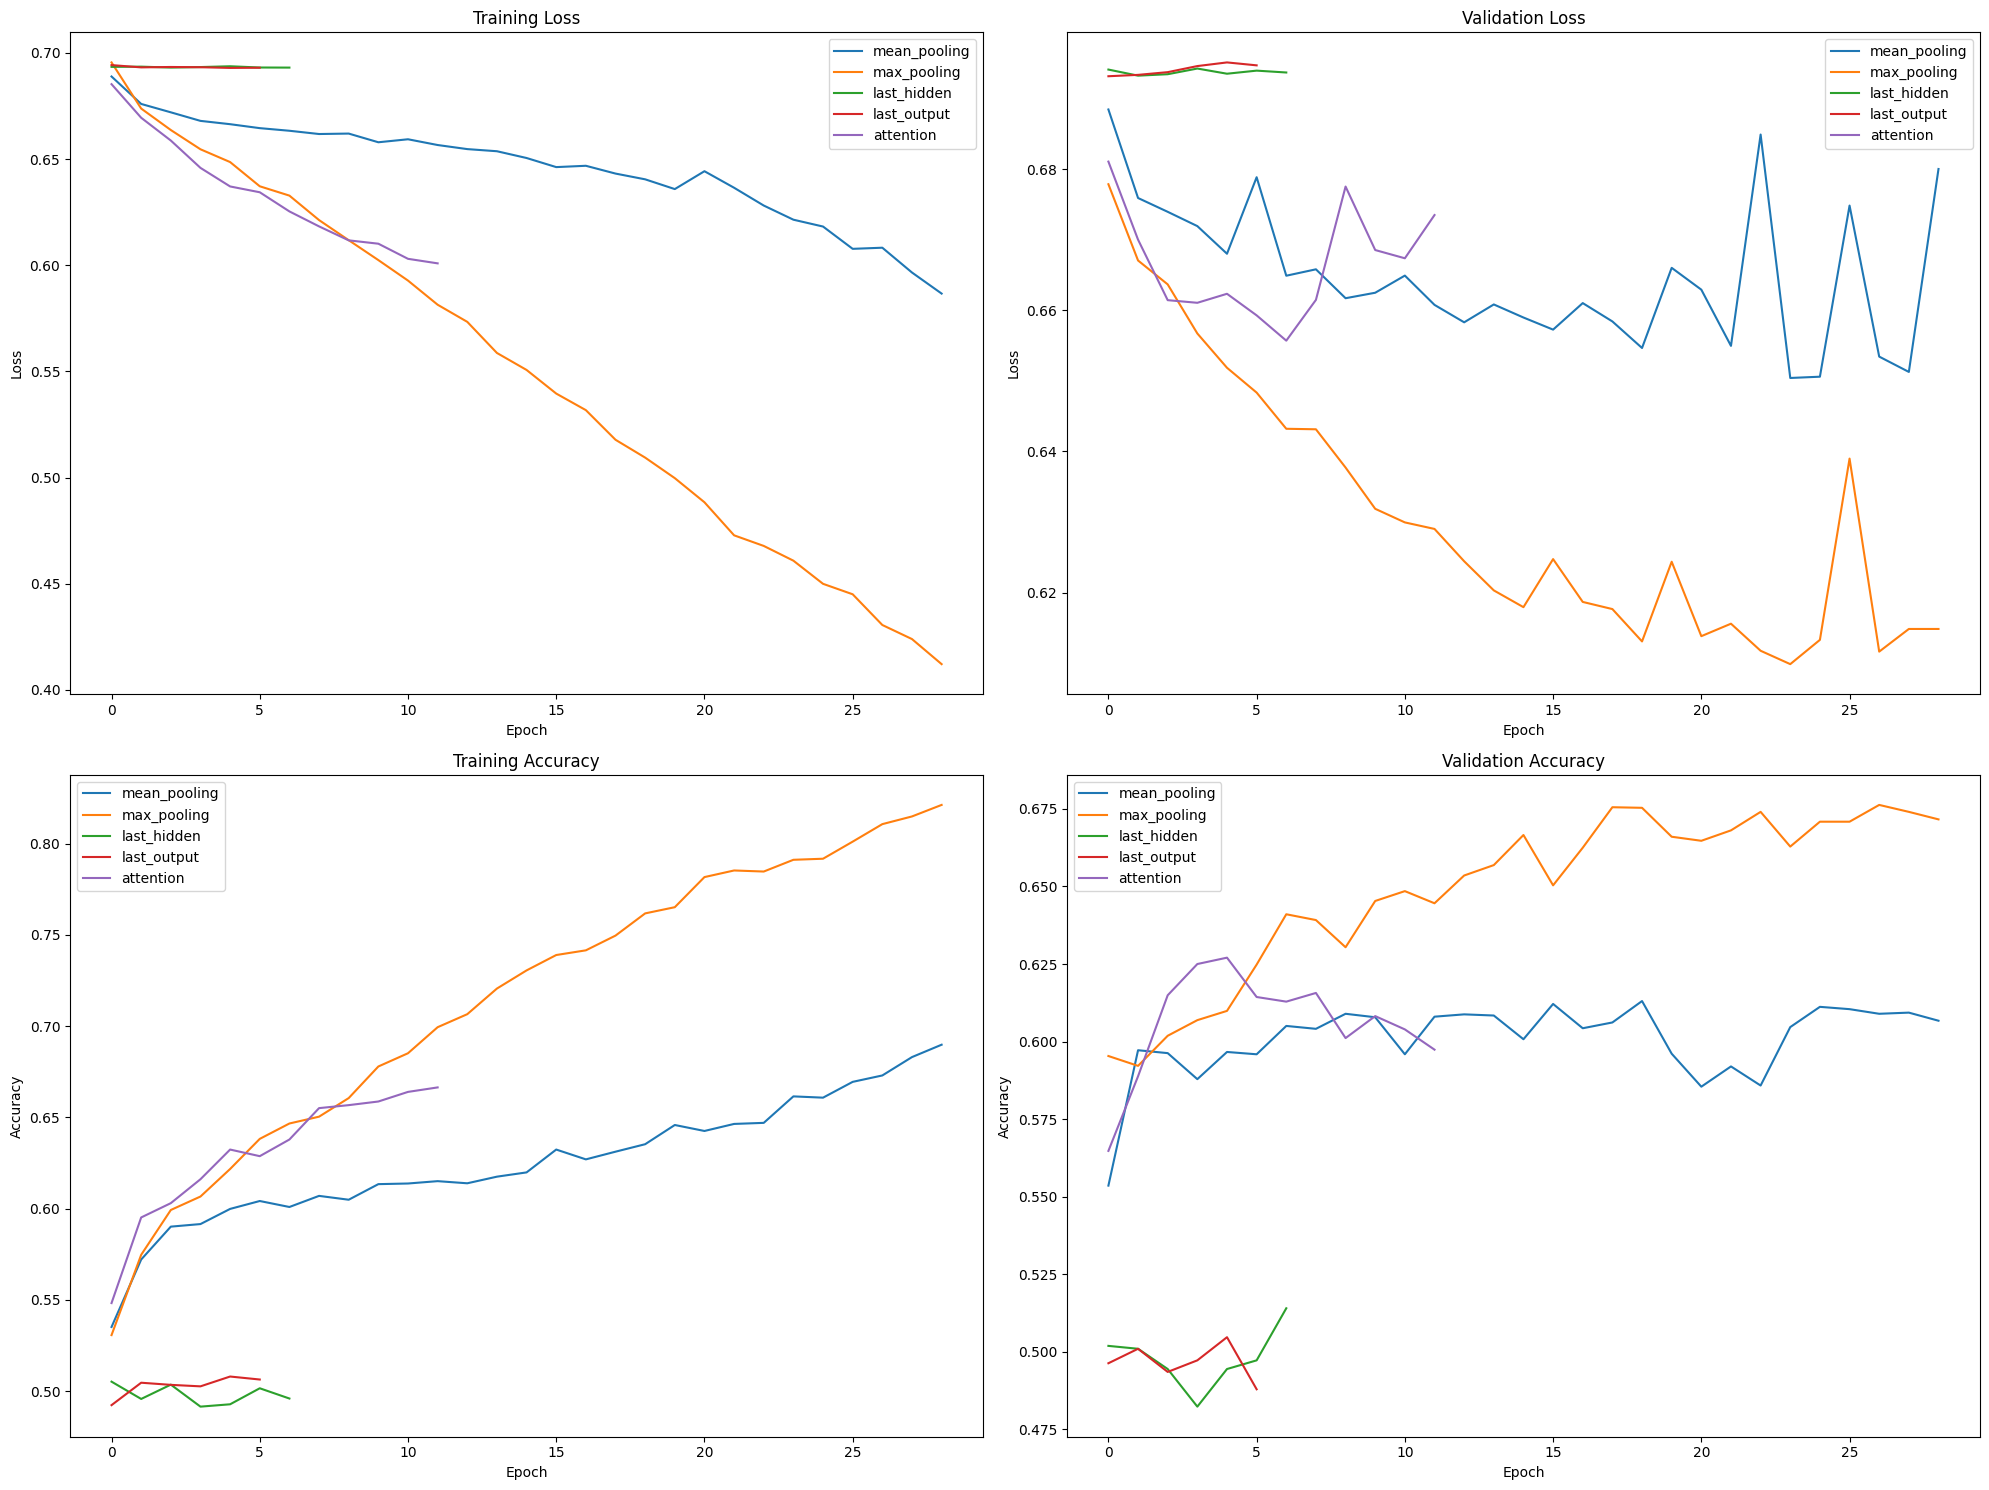

In [31]:
# plotting

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 15))

for method in aggregation_methods:
    ax1.plot(results[method]['train_losses'], label=method)
    ax2.plot(results[method]['val_losses'], label=method)
    ax3.plot(results[method]['train_accs'], label=method)
    ax4.plot(results[method]['val_accs'], label=method)

ax1.set_title('Training Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()

ax2.set_title('Validation Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()

ax3.set_title('Training Accuracy')
ax3.set_xlabel('Epoch')
ax3.set_ylabel('Accuracy')
ax3.legend()

ax4.set_title('Validation Accuracy')
ax4.set_xlabel('Epoch')
ax4.set_ylabel('Accuracy')
ax4.legend()

plt.tight_layout()
plt.savefig('aggregation_methods_comparison.png')
plt.show()

# Part 3. Enhancement


## Part 3.1 Update the word embeddings during the training process



In [32]:
class RNNUpdateEmbedding(nn.Module):
    def __init__(
        self,
        vocab_size,
        embedding_dim,
        hidden_dim,
        output_dim,
        pad_idx,
        embedding_matrix,
        freeze_embeddings=False,
        aggregation_method="max_pooling",
        dropout_rate=0.2,
    ):
        super().__init__()

        # convert numpy embedding matrix to tensor
        embedding_tensor = torch.FloatTensor(embedding_matrix)

        self.embedding = nn.Embedding.from_pretrained(
            embedding_tensor, padding_idx=pad_idx, freeze=freeze_embeddings
        )

        self.rnn = nn.RNN(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout_rate)
        # attention layer for attention aggregation method
        self.attention = nn.Linear(hidden_dim, 1)

        self.aggregation_method = aggregation_method

    def forward(self, text):
        # embedded = self.embedding(text)
        embedded = self.dropout(self.embedding(text))
        output, hidden = self.rnn(embedded)

        if self.aggregation_method == "last_hidden":
            # use the last hidden state
            sentence_repr = hidden.squeeze(0)
        elif self.aggregation_method == "last_output":
            # use the last output
            sentence_repr = output[:, -1, :]
        elif self.aggregation_method == "mean_pooling":
            # average all outputs
            sentence_repr = torch.mean(output, dim=1)
        elif self.aggregation_method == "max_pooling":
            # max pooling over the sequence
            sentence_repr, _ = torch.max(output, dim=1)
        elif self.aggregation_method == "attention":
            # Attention mechanism
            attention_weights = F.softmax(self.attention(output), dim=1)
            sentence_repr = torch.sum(attention_weights * output, dim=1)
        sentence_repr = self.dropout(sentence_repr)
        return self.fc(sentence_repr)

In [33]:
vocab_size = len(word_to_index)
embedding_dim = embedding_matrix.shape[1]  # match word2vec vector size
hidden_dim = 256
output_dim = 2
pad_idx = word_to_index["<PAD>"] if "<PAD>" in word_to_index else 0

model = RNNUpdateEmbedding(
    vocab_size,
    embedding_dim,
    hidden_dim,
    output_dim,
    pad_idx,
    embedding_matrix,
    freeze_embeddings=False,
    aggregation_method="max_pooling",
)

# verify embedding layer
print(f"Embedding layer shape: {model.embedding.weight.shape}")
print(f"Embedding layer requires gradient: {model.embedding.weight.requires_grad}")

Embedding layer shape: torch.Size([8819, 100])
Embedding layer requires gradient: True


In [105]:
model.apply(lambda m: m.reset_parameters() if hasattr(m, "reset_parameters") else None)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(
    model.parameters(), lr=best_params["lr"], weight_decay=best_params["weight_decay"]
)

final_val_loss, final_val_acc = train_and_evaluate(
    model,
    train_dataloader,
    val_dataloader,
    criterion,
    optimizer,
    best_params["num_epochs"],
    best_params["patience"],
)

print(f"Final validation loss: {final_val_loss:.4f}")
print(f"Final validation accuracy: {final_val_acc:.4f}")

# Save the best model
torch.save(model.state_dict(), "./saved_models/part_3_2.pth")

Final validation loss: 0.5681
Final validation accuracy: 0.6938


In [34]:
best_params_enhanced_rnn, best_val_loss_enhanced_rnn, best_val_acc_enhanced_rnn = (
    hyperparameter_tuning(model, train_dataloader, val_dataloader)
)
print(f"Best parameters: {best_params_enhanced_rnn}")
print(f"Best validation loss: {best_val_loss_enhanced_rnn:.4f}")
print(f"Best validation accuracy: {best_val_acc_enhanced_rnn:.4f}")

# train using the best parameters
model.apply(lambda m: m.reset_parameters() if hasattr(m, "reset_parameters") else None)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(
    model.parameters(),
    lr=best_params_enhanced_rnn["lr"],
    weight_decay=best_params_enhanced_rnn["weight_decay"],
)

final_val_loss_enhanced_rnn, final_val_acc_enhanced_rnn = train_and_evaluate(
    model,
    train_dataloader,
    val_dataloader,
    criterion,
    optimizer,
    best_params_enhanced_rnn["num_epochs"],
    best_params_enhanced_rnn["patience"],
)

print(f"Final validation loss: {final_val_loss_enhanced_rnn:.4f}")
print(f"Final validation accuracy: {final_val_acc_enhanced_rnn:.4f}")

# Save the best model
torch.save(model.state_dict(), "./saved_models/part_3_1.pth")

Best parameters: {'batch_size': 16, 'lr': 0.001, 'num_epochs': 50, 'patience': 5, 'weight_decay': 1e-05}
Best validation loss: 0.5498
Best validation accuracy: 0.7392
Final validation loss: 0.5726
Final validation accuracy: 0.7522


In [35]:
model.load_state_dict(torch.load("./saved_models/part_3_1.pth"))

model.eval()
test_loss = 0
all_predictions = []
all_labels = []

with torch.no_grad():
    for inputs, label in test_dataloader:
        outputs = model(inputs)
        loss = criterion(outputs, label)

        test_loss += loss.item()
        _, predicted = torch.max(outputs, 1)

        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(label.cpu().numpy())

test_loss /= len(test_dataloader)
test_acc = accuracy_score(all_labels, all_predictions)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")

/var/folders/_j/9p9lzy_s3638t1nklml8vb400000gn/T/ipykernel_3147/1144306666.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("./saved_mode

Test Loss: 0.5406
Test Accuracy: 0.7795


## Part 3.2 Mitigating OOV


### Mitigating OOV using FastText

In [52]:

from gensim.models import FastText

corpus = tokenized_sentences
fasttext_model = FastText(
    sentences=corpus, vector_size=100, window=3, min_count=2, workers=4, sg=1
)

fasttext_vocab = set(fasttext_model.wv.key_to_index)

ft_oov_words = original_vocab - fasttext_vocab

print(len(ft_oov_words))

7866


In [53]:
# Replace all OOV words with <UNK>

# define the UNK and PAD token
UNK_TOKEN = '<UNK>'
PAD_TOKEN = '<PAD>'

### Embedding matrix

In [61]:
# empty set for storing unique words
ft_final_vocab = set()

for sentence in tokenized_sentences:
    for word in sentence:
        # add each word in the sentence to the final_vocab set
        ft_final_vocab.add(word)

# add '<PAD>' to the vocabulary
ft_final_vocab.add(PAD_TOKEN)
ft_final_vocab.add(UNK_TOKEN)


# create the dictionary that maps each word in final_vocab to a unique index
ft_word_to_index = {word: i for i, word in enumerate(ft_final_vocab)}

ft_embedding_dim = fasttext_model.vector_size

# initialize embedding matrix with number of vocab and embedding dimension
ft_embedding_matrix = np.zeros((len(ft_word_to_index), ft_embedding_dim))

# fill the embedding matrix with the corresponding word vectors
# since fasttext can provide vectors for OOV words, we can use the following code to fill the embedding matrix
for word, i in ft_word_to_index.items():
    ft_embedding_matrix[i] = fasttext_model.wv[word]


print(f"Shape of embedding matrix: {ft_embedding_matrix.shape}")

Shape of embedding matrix: (8819, 100)


In [59]:
ft_train_X = [
    words_to_indices(sentence, ft_word_to_index) for sentence in train_dataset["text"]
]
ft_train_y = train_dataset["label"]
ft_val_X = [
    words_to_indices(sentence, ft_word_to_index)
    for sentence in validation_dataset["text"]
]
ft_val_y = validation_dataset["label"]
ft_test_X = [
    words_to_indices(sentence, ft_word_to_index) for sentence in test_dataset["text"]
]
ft_test_y = test_dataset["label"]


ft_train_dataloader = create_dataloader(ft_train_X, ft_train_y, shuffle=True)
ft_val_dataloader = create_dataloader(ft_val_X, ft_val_y, shuffle=False)
ft_test_dataloader = create_dataloader(ft_test_X, ft_test_y, shuffle=False)

# convert embedding_matrix to tensor
ft_embedding_matrix = torch.FloatTensor(ft_embedding_matrix)

### Re-train RNN model using updated embedded matrix

In [43]:
ft_vocab_size = len(ft_word_to_index)
ft_embedding_dim = ft_embedding_matrix.shape[1]  # match word2vec vector size
hidden_dim = 256
output_dim = 2
ft_pad_idx = ft_word_to_index["<PAD>"] if "<PAD>" in ft_word_to_index else 0

model = RNNUpdateEmbedding(
    vocab_size,
    ft_embedding_dim,
    hidden_dim,
    output_dim,
    ft_pad_idx,
    ft_embedding_matrix,
    freeze_embeddings=False,
    aggregation_method="max_pooling",
)

# verify embedding layer
print(f"Embedding layer shape: {model.embedding.weight.shape}")
print(f"Embedding layer requires gradient: {model.embedding.weight.requires_grad}")

Embedding layer shape: torch.Size([8819, 100])
Embedding layer requires gradient: True


In [44]:
model.apply(lambda m: m.reset_parameters() if hasattr(m, "reset_parameters") else None)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(
    model.parameters(), lr=best_params["lr"], weight_decay=best_params["weight_decay"]
)

final_val_loss, final_val_acc = train_and_evaluate(
    model,
    ft_train_dataloader,
    ft_val_dataloader,
    criterion,
    optimizer,
    best_params["num_epochs"],
    best_params["patience"],
)

print(f"Final validation loss: {final_val_loss:.4f}")
print(f"Final validation accuracy: {final_val_acc:.4f}")

# Save the best model
torch.save(model.state_dict(), "./saved_models/part_3_2.pth")

Final validation loss: 0.5993
Final validation accuracy: 0.6896


In [45]:
best_params_enhanced_rnn, best_val_loss_enhanced_rnn, best_val_acc_enhanced_rnn = (
    hyperparameter_tuning(model, train_dataloader, val_dataloader)
)
print(f"Best parameters: {best_params_enhanced_rnn}")
print(f"Best validation loss: {best_val_loss_enhanced_rnn:.4f}")
print(f"Best validation accuracy: {best_val_acc_enhanced_rnn:.4f}")

# train using the best parameters
model.apply(lambda m: m.reset_parameters() if hasattr(m, "reset_parameters") else None)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(
    model.parameters(),
    lr=best_params_enhanced_rnn["lr"],
    weight_decay=best_params_enhanced_rnn["weight_decay"],
)

final_val_loss_enhanced_rnn, final_val_acc_enhanced_rnn = train_and_evaluate(
    model,
    ft_train_dataloader,
    ft_val_dataloader,
    criterion,
    optimizer,
    best_params_enhanced_rnn["num_epochs"],
    best_params_enhanced_rnn["patience"],
)

print(f"Final validation loss: {final_val_loss_enhanced_rnn:.4f}")
print(f"Final validation accuracy: {final_val_acc_enhanced_rnn:.4f}")

# Save the best model
torch.save(model.state_dict(), "./saved_models/part_3_2.pth")

Best parameters: {'batch_size': 32, 'lr': 0.001, 'num_epochs': 50, 'patience': 5, 'weight_decay': 1e-05}
Best validation loss: 0.5443
Best validation accuracy: 0.7470
Final validation loss: 0.5484
Final validation accuracy: 0.7442


In [46]:
model.load_state_dict(torch.load("./saved_models/part_3_2.pth"))

model.eval()
test_loss = 0
all_predictions = []
all_labels = []

with torch.no_grad():
    for inputs, label in ft_test_dataloader:
        outputs = model(inputs)
        loss = criterion(outputs, label)

        test_loss += loss.item()
        _, predicted = torch.max(outputs, 1)

        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(label.cpu().numpy())

test_loss /= len(ft_test_dataloader)
test_acc = accuracy_score(all_labels, all_predictions)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")

Test Loss: 0.6701
Test Accuracy: 0.7533


/var/folders/_j/9p9lzy_s3638t1nklml8vb400000gn/T/ipykernel_3147/1828272481.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("./saved_mode